## 导入依赖

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from config import *

## 读入图像

In [2]:
img = cv2.imread('./data/image_raw/0.png')

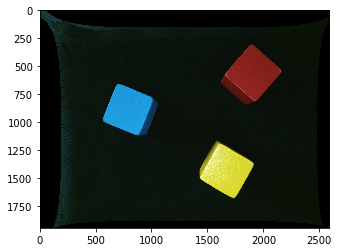

In [3]:
plt.imshow(img[:, :, ::-1])

## 图像二值化

In [4]:
bin_red = cv2.inRange(img, lowerb=RED_BLOCK_LOWERB, upperb=RED_BLOCK_UPPERB)

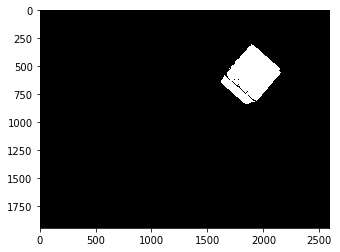

In [5]:
plt.imshow(bin_red, cmap='gray')

找到最大的连通域

In [6]:
def find_contours(img_bin):
    contours = None
    if cv2.__version__[0] == '4':
        contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    else:
        img, contours, hierarchy =  cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [7]:
red_contours = find_contours(bin_red)

In [8]:
len(red_contours)

18

找到最大的颜色阈值

In [47]:
# 候选矩形区域
candi_rects = [cv2.boundingRect(cnt) for cnt in red_contours]

print(candi_rects)
# TODO 添加矩形面积的约束 filter
max_rect = max(candi_rects, key=lambda rect: rect[2] * rect[3])

[(1657, 563, 3, 3), (1661, 559, 2, 2), (1664, 555, 2, 2), (1666, 553, 1, 1), (2154, 540, 1, 3), (1668, 540, 10, 12), (2153, 537, 1, 1), (2150, 532, 1, 1), (1702, 518, 1, 1), (1814, 379, 4, 4), (1851, 335, 5, 5), (1857, 332, 2, 2), (1860, 320, 9, 11), (1870, 313, 7, 7), (1881, 310, 1, 1), (1883, 309, 1, 1), (1885, 308, 1, 1), (1618, 307, 538, 534)]


> TODO 优化这部分可以缩放之后再进行色块查找(获得大的范围)

In [48]:
max_rect

(1618, 307, 538, 534)

Canny求边缘

True

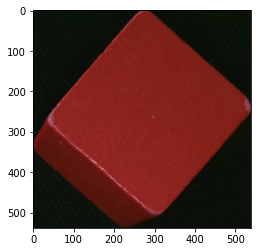

In [49]:
roi_rect = max_rect # cv2.boundingRect(rect_contour)
x, y, w, h = roi_rect
# 获取ROI区域的原始图像
roi_img = img[y: y+w, x:x+w]
plt.imshow(roi_img[:, :, ::-1])

cv2.imwrite('roi_img.png', roi_img)

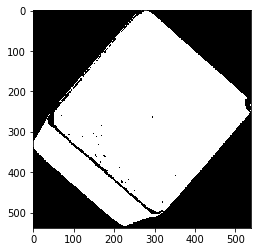

In [12]:
roi_binary = bin_red[y: y+w, x:x+w]
plt.imshow(roi_binary, cmap="gray")

求边缘

True

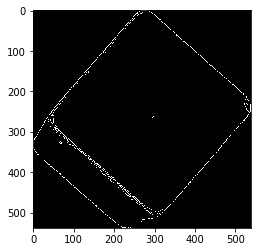

In [13]:
bin_canny = cv2.Canny(roi_img,40,100)
plt.imshow(bin_canny, cmap='gray')
cv2.imwrite('bin_cany.png', bin_canny)

In [14]:
# kernel = np.ones((3,3), np.uint8)
# bin_dilate = cv2.dilate(bin_canny, kernel,  iterations=1)
# plt.imshow(bin_dilate, cmap='gray')
# cv2.imwrite('bin_dilate.png', bin_dilate)
bin_dilate = bin_canny

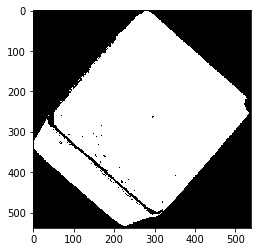

In [15]:
roi_binary2 = cv2.bitwise_and(cv2.bitwise_not(bin_dilate), roi_binary)
plt.imshow(roi_binary2, cmap='gray')

留下最大的连通域

In [16]:
candi_contours = find_contours(roi_binary2)
# 候选最小面积外接矩形区域
candi_rects = [(cnt, cv2.minAreaRect(cnt)) for cnt in candi_contours]
# TODO 添加矩形面积的约束 filter
max_cnt, max_rect = max(candi_rects, key=lambda e: e[1][1][0] * e[1][1][1]) # 依据面积进行筛选

In [17]:
max_rect

((291.20355224609375, 250.5531005859375),
 (369.70330810546875, 373.56024169921875),
 -48.8140754699707)

True

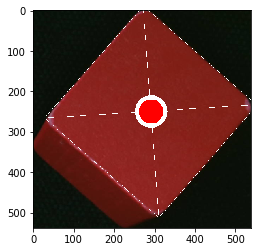

In [18]:
canvas = np.copy(roi_img)
line_thickness = 1 # 笔触的宽度
# 获取矩形的四个角点的坐标
rect_contour = np.int64(cv2.boxPoints(max_rect))
pt_a, pt_b, pt_c, pt_d = [tuple(pt) for pt in rect_contour]
# 绘制外接边框
canvas = cv2.drawContours(canvas, [rect_contour], 0, (255,255,255), line_thickness)
line_thickness = 1 # 笔触的宽度 (调细)
# 绘制对角虚线
cv2.line(img=canvas, pt1=pt_a, pt2=pt_c, color=(255, 255, 255), thickness=line_thickness)
cv2.line(img=canvas, pt1=pt_b, pt2=pt_d, color=(255, 255, 255), thickness=line_thickness)
# 物块中心
cx, cy = [int(value) for value in  max_rect[0]]
# 在中间画个小圆圈
cv2.circle(img=canvas, center=(cx, cy), radius=40, color=(255, 255, 255), thickness=-1)
cv2.circle(img=canvas, center=(cx, cy), radius=30, color=(0, 0, 255), thickness=-1)

plt.imshow(canvas[:, :, ::-1])
cv2.imwrite('canvas.png', canvas)

> TODO 再进一步优化就是用多边形去获取物块的四个角点

True

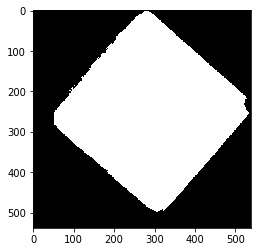

In [44]:
roi_binary3 = np.zeros_like(roi_binary)
roi_binary3 = cv2.drawContours(roi_binary3, [max_cnt], color=255, contourIdx=0, thickness=-1)

plt.imshow(roi_binary3, cmap='gray')

cv2.imwrite('roi_binary3.png', roi_binary3)

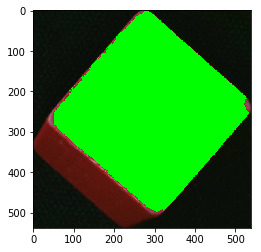

In [22]:
canvas2 = np.copy(roi_img)
canvas2 = cv2.drawContours(canvas2, [max_cnt], color=(0, 255, 0), contourIdx=0, thickness=-1)
plt.imshow(canvas2[:,:,::-1])

拟合四个角点, 存在一定的可能边边角角的被损伤了

外接四边形近似

A1 = (277, 2)
B1 = (52, 280)
C1 = (308, 497)
D1 = (535, 250)


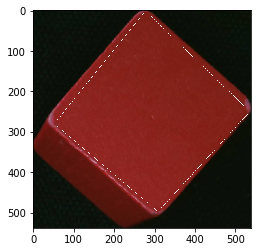

In [43]:
# 多变形近似
epsilon = 0.12*cv2.arcLength(max_cnt,True)
# 返回点集，格式与contours相同
approx_cnt = cv2.approxPolyDP(max_cnt,epsilon,True)

if len(approx_cnt) != 4:
    print("Error,　多变形拟合的角点个数为: {}".format(approx_cnt))
    print(approx_cnt)

# 获取拟合四边形的四个顶点
A1, B1, C1, D1 =  [pt[0] for pt in approx_cnt]
print("A1 = ({}, {})".format(*A1))
print("B1 = ({}, {})".format(*B1))
print("C1 = ({}, {})".format(*C1))
print("D1 = ({}, {})".format(*D1))

canvas = np.copy(roi_img)
line_thickness = 1 # 笔触的宽度

# 绘制外接边框
canvas = cv2.drawContours(canvas, [approx_cnt], 0, (255,255,255), line_thickness)
line_thickness = 10 # 笔触的宽度 (调细)
plt.imshow(canvas[:, :, ::-1])


**多边形近似的效果还不如外接四边形.**

> TODO 寻找色块的外切多边形

**凸包**

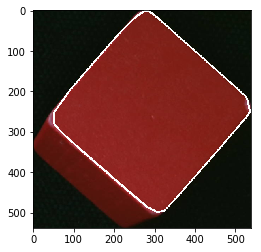

In [27]:
convex_hull = cv2.convexHull(max_cnt, )
canvas = np.copy(roi_img)
line_thickness = 3 # 笔触的宽度
# 绘制外接边框
canvas = cv2.drawContours(canvas, [convex_hull], 0, (255,255,255), line_thickness)

plt.imshow(canvas[:, :, ::-1])

## PNP问题求解